In [1]:
import numpy as np
import copy
from IPython.display import HTML
import matplotlib.pyplot as plt
import dill

import SimPEG as simpeg
from SimPEG.EM import NSEM

import sys
sys.path.append("../../../../pymatsolver/")
from pymatsolver import PardisoSolver
sys.path.append("../../../../../Dropbox/PhD_UBC/telluricpy/")
import telluricpy

# Set some matplotlib settings
%matplotlib inline


Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    


In [2]:
# Define the area of interest
bw, be = -250., 250
bs, bn = -250., 250.
bb, bt = -500.,0.

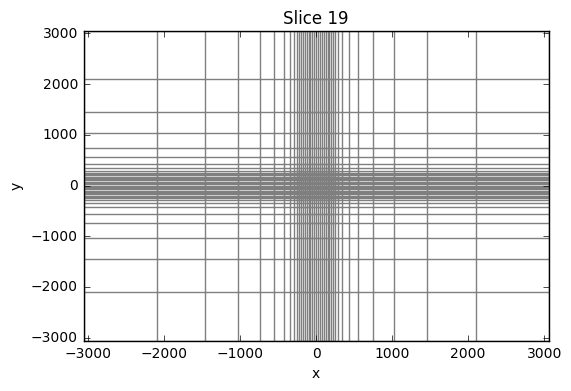

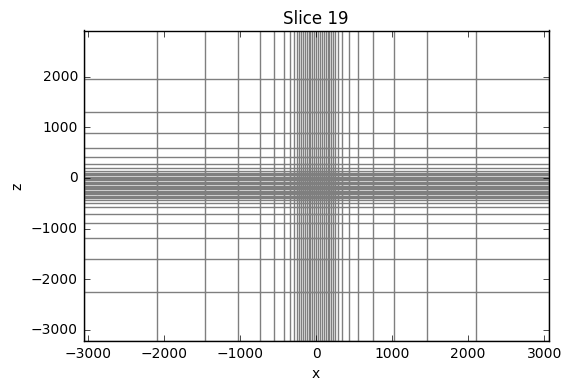

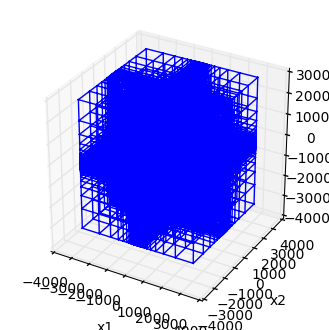

54872
168948


In [17]:
#Cell size
csx, csy, csz = 25.,25.,25.
# Number of core cells in each directiPon s
ncx, ncy, ncz = 20,20,20.
# Number of padding cells to add in each direction
npad = 9
growrate = 1.5
# Vectors of cell lengthts in each direction
hx = [(csx,npad, -growrate),(csx,ncx),(csx,npad,growrate)]
hy = [(csy,npad, -growrate),(csy,ncy),(csy,npad, growrate)]
hz = [(csz,npad,-growrate),(csz,ncz),(csy,npad, growrate)]
#hz = [(csz,npad, -1.5),(csz,ncz),(csz,npad,1.5)]

# nrCcore = [6, 5, 4, 2, 2, 2, 2]
airPad = simpeg.Utils.meshTensor([(csz,npad,growrate)])
# vCore = np.concatenate([ np.ones(i)*s for i, s in zip(nrCcore,(simpeg.Utils.meshTensor([(csz,1),(csz,5,1.3)])))])[::-1]
# botPad = simpeg.Utils.meshTensor([(vCore[0],2,-1.5)])
# hz = np.concatenate((botPad,vCore,airPad))

# Create mesh
mesh = simpeg.Mesh.TensorMesh([hx, hy, hz],x0="CCN")
# Map mesh coordinates from local to UTM coordiantes
mesh.x0[2] = mesh.x0[2]+np.sum(airPad) + 100
#mesh.x0[2] = mesh.x0[2]- csz/2.#-np.max(mesh.vectorCCz[npad:-npad]) 

mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True)
mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True, normal="Y")
mesh.plotGrid()
plt.gca().set_aspect('equal')
plt.show()

print mesh.nC
print mesh.nF

In [18]:
mesh.vectorNx

array([-3058.25195312, -2097.16796875, -1456.4453125 , -1029.296875  ,
        -744.53125   ,  -554.6875    ,  -428.125     ,  -343.75      ,
        -287.5       ,  -250.        ,  -225.        ,  -200.        ,
        -175.        ,  -150.        ,  -125.        ,  -100.        ,
         -75.        ,   -50.        ,   -25.        ,     0.        ,
          25.        ,    50.        ,    75.        ,   100.        ,
         125.        ,   150.        ,   175.        ,   200.        ,
         225.        ,   250.        ,   287.5       ,   343.75      ,
         428.125     ,   554.6875    ,   744.53125   ,  1029.296875  ,
        1456.4453125 ,  2097.16796875,  3058.25195312])

In [19]:
sig_air = 1e-8
sphere_depth = 100.
sig_east = 1e-2
sig_west = 1e-1
#sphere_r = 50.
sigma = sig_east*np.ones(mesh.nC)

#West
west = mesh.gridCC[:,0]>0
sigma[west] = sig_west

#air cells
air = mesh.gridCC[:,2]>0.
sigma[air]=sig_air

# Get a 1D background model
bgsigma = mesh.r(sigma,'CC','CC','M')[0,0,:]

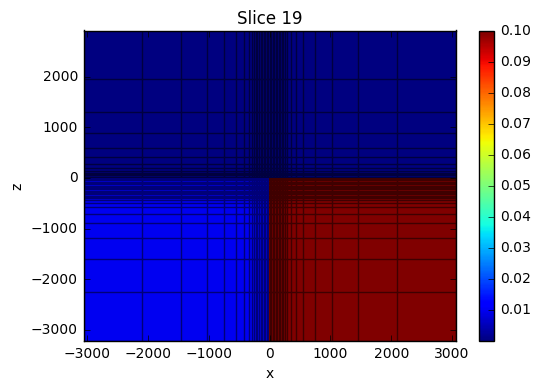

In [34]:
a = mesh.plotSlice(sigma, grid=True, normal="Y")
#plt.gca().set_xlim([-250.,250])
#plt.gca().set_ylim([-500.,10.])
plt.colorbar(a[0])

In [21]:
freqs = np.logspace(5,2,13)
print freqs

[ 100000.           56234.13251903   31622.77660168   17782.79410039
   10000.            5623.4132519     3162.27766017    1778.27941004
    1000.             562.34132519     316.22776602     177.827941       100.        ]


In [22]:
print 500./np.sqrt(freqs*sig_east)

[  15.8113883    21.08482517   28.11706626   37.49471047   50.
   66.67607161   88.9139705   118.56868528  158.11388301  210.84825171
  281.1706626   374.94710467  500.        ]


In [25]:
# Make the rxLocations file
x,y,z = np.meshgrid(np.arange(-250,251,25),np.arange(-250,251,25),[0.])
locs = np.hstack((x.reshape(-1,1),y.reshape(-1,1),z.reshape(-1,1)))


In [26]:
locs

array([[-250., -250.,    0.],
       [-225., -250.,    0.],
       [-200., -250.,    0.],
       ..., 
       [ 200.,  250.,    0.],
       [ 225.,  250.,    0.],
       [ 250.,  250.,    0.]])

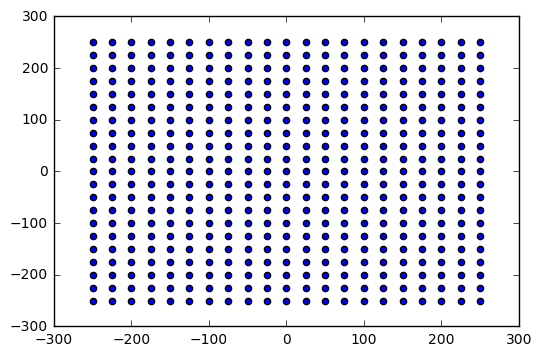

In [27]:
plt.scatter(locs[:,0],locs[:,1])

In [28]:
rxList = []        
for rx_orientation in ['xx', 'xy', 'yx', 'yy']:
    rxList.append(NSEM.Rx.Point_impedance3D(locs,rx_orientation, 'real'))
    rxList.append(NSEM.Rx.Point_impedance3D(locs,rx_orientation, 'imag'))            
for rx_orientation in ['zx','zy']:
    rxList.append(NSEM.Rx.Point_tipper3D(locs,rx_orientation, 'real'))
    rxList.append(NSEM.Rx.Point_tipper3D(locs,rx_orientation, 'imag'))
# Source list
srcList =[]
for freq in freqs:
    srcList.append(NSEM.Src.Planewave_xy_1Dprimary(rxList,freq))
# Survey MT
survey = NSEM.Survey(srcList)
# Background 1D model
sigma1d = mesh.r(sigma,'CC','CC','M')[0,0,:]
## Setup the problem object
problem = NSEM.Problem3D_ePrimSec(mesh, sigmaMap=simpeg.Maps.IdentityMap(), sigmaPrimary = sigma1d)
problem.verbose = True

problem.Solver = PardisoSolver
problem.pair(survey)

import time
## Calculate the fields
stTime = time.time()
print 'Starting calculating field solution at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sys.stdout.flush()
FmtSer = problem.fields(sigma)
print 'Ended calculation field at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print 'Ran for {:f}'.format(time.time()-stTime)

## Project data
stTime = time.time()
print 'Starting projecting fields to data at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sys.stdout.flush()
mtData = NSEM.Data(survey,survey.eval(FmtSer))
print 'Ended projection of fields at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print 'Ran for {:f}'.format(time.time()-stTime)

Starting calculating field solution at 2016-12-21 18:19:55
Starting work for 1.000e+02
Ran for 184.384000 seconds
Starting work for 1.778e+02
Ran for 196.522000 seconds
Starting work for 3.162e+02
Ran for 178.559000 seconds
Starting work for 5.623e+02
Ran for 174.089000 seconds
Starting work for 1.000e+03
Ran for 173.511000 seconds
Starting work for 1.778e+03
Ran for 177.100000 seconds
Starting work for 3.162e+03
Ran for 172.096000 seconds
Starting work for 5.623e+03
Ran for 168.310000 seconds
Starting work for 1.000e+04
Ran for 175.681000 seconds
Starting work for 1.778e+04
Ran for 173.689000 seconds
Starting work for 3.162e+04
Ran for 171.535000 seconds
Starting work for 5.623e+04
Ran for 175.217000 seconds
Starting work for 1.000e+05
Ran for 170.539000 seconds
Ended calculation field at 2016-12-21 18:58:14
Ran for 2298.917000
Starting projecting fields to data at 2016-12-21 18:58:14
Ended projection of fields at 2016-12-21 18:58:58
Ran for 43.707000


In [29]:
# Pickle the data
mtData.survey.unpair()

dill.dump(mtData,open('vertical_contact_mtData_1e2_1e1.pklb','wb'))

In [30]:
mtData = dill.load(open('vertical_contact_mtData_1e2_1e1.pklb','rb'))

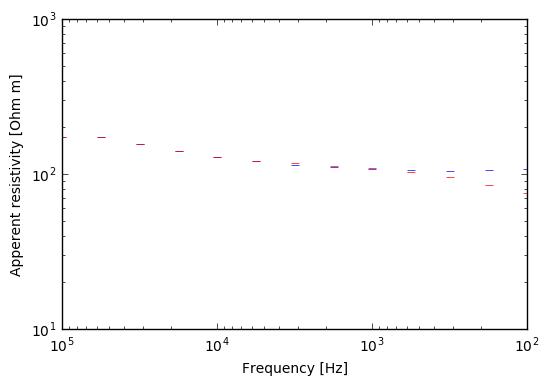

In [33]:
mtData.plot_app_res(np.array([-250.,0.]))

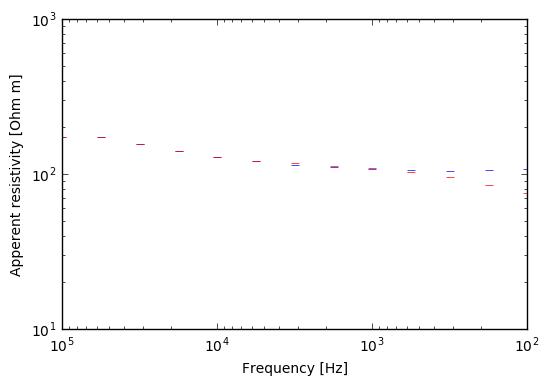

In [32]:
mtData.plot_app_res(np.array([-250.,0.]))